This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [9]:
len(temperature)

420451

**Plotting the temperature timeseries**

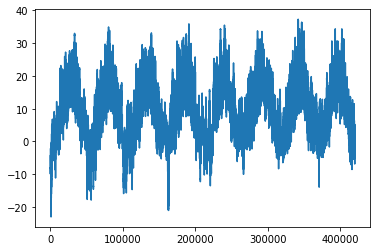

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

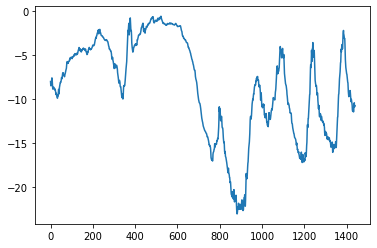

In [4]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 8ms/step - loss: 18.0414 - mae: 3.2815 - val_loss: 15.8560 - val_mae: 3.2014
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 10.9962 - mae: 2.6104 - val_loss: 10.8814 - val_mae: 2.6104
Epoch 3/10
819/819 [==============================] - 6s 8ms/step - loss: 9.9515 - mae: 2.4794 - val_loss: 10.4690 - val_mae: 2.5680
Epoch 4/10
819/819 [==============================] - 7s 8ms/step - loss: 9.3198 - mae: 2.4007 - val_loss: 10.5754 - val_mae: 2.5775
Epoch 5/10
819/819 [==============================] - 7s 9ms/step - loss: 8.8490 - mae: 2.3409 - val_loss: 11.9535 - val_mae: 2.7511
Epoch 6/10
819/819 [==============================] - 7s 8ms/step - loss: 8.5139 - mae: 2.2974 - val_loss: 11.4602 - val_mae: 2.6801
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 8.2533 - mae: 2.2615 - val_loss: 11.7989 - val_mae: 2.7331
Epoch 8/10
819/819 [==============================] - 7s 8ms/step -

**Plotting results**

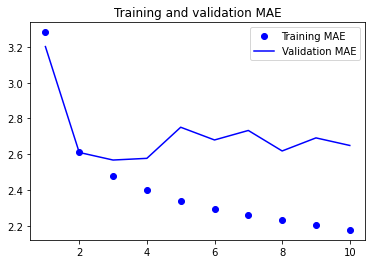

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 14s 11ms/step - loss: 24.3012 - mae: 3.8245 - val_loss: 14.7937 - val_mae: 3.0169
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 15.9905 - mae: 3.1718 - val_loss: 14.7676 - val_mae: 3.0550
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 14.4637 - mae: 3.0103 - val_loss: 16.4336 - val_mae: 3.1839
Epoch 4/10
819/819 [==============================] - 9s 10ms/step - loss: 13.5944 - mae: 2.9143 - val_loss: 15.8694 - val_mae: 3.1372
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 12.8430 - mae: 2.8330 - val_loss: 14.5791 - val_mae: 3.0194
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 12.3139 - mae: 2.7795 - val_loss: 13.4427 - val_mae: 2.8788
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 11.8306 - mae: 2.7236 - val_loss: 14.6325 - val_mae: 3.0115
Epoch 8/10
819/819 [==============================] - 

### A first recurrent baseline

**A simple LSTM-based model**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 20ms/step - loss: 44.9745 - mae: 4.9021 - val_loss: 13.3430 - val_mae: 2.7643
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 11.1588 - mae: 2.5871 - val_loss: 9.6327 - val_mae: 2.4133
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 9.8009 - mae: 2.4353 - val_loss: 9.7480 - val_mae: 2.4301
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 9.2203 - mae: 2.3637 - val_loss: 10.0126 - val_mae: 2.4527
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 8.9085 - mae: 2.3197 - val_loss: 9.6892 - val_mae: 2.4175
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 8.6525 - mae: 2.2841 - val_loss: 9.7567 - val_mae: 2.4354
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 8.4512 - mae: 2.2579 - val_loss: 9.6885 - val_mae: 2.4183
Epoch 8/10
819/819 [==============================] - 16s 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 421s 512ms/step - loss: 26.5125 - mae: 3.8186 - val_loss: 9.5932 - val_mae: 2.4053
Epoch 2/50
819/819 [==============================] - 415s 507ms/step - loss: 14.8026 - mae: 2.9871 - val_loss: 9.1992 - val_mae: 2.3584
Epoch 3/50
819/819 [==============================] - 402s 490ms/step - loss: 14.0068 - mae: 2.9015 - val_loss: 9.4599 - val_mae: 2.3897
Epoch 4/50
819/819 [==============================] - 401s 489ms/step - loss: 13.5495 - mae: 2.8504 - val_loss: 9.2397 - val_mae: 2.3658
Epoch 5/50
819/819 [==============================] - 400s 488ms/step - loss: 13.1615 - mae: 2.8059 - val_loss: 9.1505 - val_mae: 2.3549
Epoch 6/50
819/819 [==============================] - 399s 487ms/step - loss: 12.6558 - mae: 2.7513 - val_loss: 9.1966 - val_mae: 2.3719
Epoch 7/50
819/819 [==============================] - 399s 487ms/step - loss: 12.3331 - mae: 2.7153 - val_loss: 9.4077 - val_mae: 2.4027
Epoch 8/50
819/819 [=====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 762s 927ms/step - loss: 25.3509 - mae: 3.7194 - val_loss: 9.4054 - val_mae: 2.3717
Epoch 2/50
819/819 [==============================] - 757s 924ms/step - loss: 13.8434 - mae: 2.8811 - val_loss: 9.4833 - val_mae: 2.3851
Epoch 3/50
819/819 [==============================] - 759s 927ms/step - loss: 13.1641 - mae: 2.8115 - val_loss: 9.6242 - val_mae: 2.4059
Epoch 4/50
819/819 [==============================] - 758s 925ms/step - loss: 12.5627 - mae: 2.7507 - val_loss: 8.6795 - val_mae: 2.2781
Epoch 5/50
819/819 [==============================] - 760s 927ms/step - loss: 12.1496 - mae: 2.7036 - val_loss: 9.9991 - val_mae: 2.4574
Epoch 6/50
819/819 [==============================] - 757s 925ms/step - loss: 11.8230 - mae: 2.6707 - val_loss: 9.2346 - val_mae: 2.3544
Epoch 7/50
819/819 [==============================] - 759s 926ms/step - loss: 11.3900 - mae: 2.6213 - val_loss: 9.2312 - val_mae: 2.3632
Epoch 8/50
819/819 [=====================

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary